### Introduction to SHAP Values and Explainable AI (XAI)

- In machine learning, understanding **why** a model makes a specific prediction is often as crucial as the prediction itself.
- SHAP (SHapley Additive exPlanations) is based on cooperative game theory and offers a powerful framework for explaining model predictions.
    - The game is the prediction task for a single instance of the dataset.
    - The players are the feature values of the instance collaborating to receive the gain.
    - The gain is the difference between the actual prediction and the expected (average) prediction.
    - SHAP ensures a fair distribution of this gain among features.
    
- SHAP attributes the model’s output to the input features, answering: *“How much did each feature contribute to this prediction?”*

- SHAP original paper: https://arxiv.org/abs/1705.07874
- SHAP library: https://shap.readthedocs.io/en/latest/ 

#### Decomposing the Prediction
- SHAP decomposes a model’s prediction by attributing the difference from the expected value to individual features.

\begin{equation*} f(x) - \mathbb{E}[f(x)] = \phi_1 + \phi_2 + \dots + \phi_p 
\end{equation*}

- **Where:**
  - $\phi_i$ is the Shapley value (contribution) of feature $i$.
  - $p$ is the number of features.
  - Each $\phi_i$ represents the amount by which feature $i$ influences the prediction above or below the baseline.

    - A negative contribution means the feature reduces the prediction relative to the baseline.
    - A positive contribution means the feature increases the prediction relative to the baseline.
    
##### Understanding the Baseline (Expected Value)
- This is the expected value of the model's predictions over the entire dataset.
- It represents the average model output if no feature values were known.
- Mathematically, it's the mean prediction across all training samples:
  
\begin{equation*} \mathbb{E}[f(x)] = \frac{1}{N} \sum_{i=1}^{N} f(x_i) \end{equation*}
  


#### Mathematical Formulation of SHAP Values
\begin{equation*} \phi_i = \sum_{S \subseteq F \setminus \{i\}} \frac{|S|!(|F|-|S|-1)!}{|F|!} \left[f(S \cup \{i\}) - f(S)\right] \end{equation*}

- Where:
  - $F$ is the set of all features.
  - $S$ is a subset of features without feature $i$.
  - $f(S)$ represents the model’s prediction using only the features in $S$


#### Outputs for Classification Models  
In logistic regression, the model predicts the probability of an outcome $y$ (e.g., a binary label 0 or 1) based on a linear combination of features. The relationship is expressed as:

\begin{equation*}
\text{log-odds}(x) = \log \left( \frac{P(y = 1 \mid x)}{P(y = 0 \mid x)} \right) = \beta_0 + \sum_{j=1}^{p} \beta_j x_j
\end{equation*}

Where:
- $\text{log-odds}(x)$: The output in log-odds space.
- $\beta_0$: Intercept term.
- $\beta_j$: Coefficients for feature $x_j$.
- $x_j$: Feature values.
- $p$: Number of features.

- To convert log-odds to probabilities:

\begin{equation*}
P(y = 1 \mid x) = \frac{1}{1 + e^{-\text{log-odds}(x)}}
\end{equation*}

In [1]:
### Example
import numpy as np 
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

data = load_breast_cancer(as_frame=True)

In [2]:
X = data["data"]

In [3]:
y = data["target"].to_numpy()

In [4]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
# Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=1)

# Train a machine learning model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(class_weight="balanced", max_iter=10000)
clf.fit(X_train, y_train)

# Make prediction on the testing data
y_pred = clf.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        63
           1       0.94      0.95      0.95       108

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



In [6]:
!pip install shap
import shap 

explainer = shap.Explainer(clf, X_train)

shap_values = explainer(X_test)

- Line 1: `explainer = shap.Explainer(clf, X_train)`

    - `shap.Explainer(...)`: This is the core function from the SHAP library that creates an "explainer" object. The explainer's job is to calculate the contribution of each feature to the model's predictions.
    - `clf`: This represents your trained machine learning model (classifier). It could be any model supported by SHAP, such as a scikit-learn model (e.g., RandomForestClassifier, GradientBoostingClassifier), XGBoost, LightGBM, or others.
    - `X_train`: This is your training dataset, which is crucial for the explainer to understand the baseline behavior of your model. SHAP needs to know how the model behaves on typical data to determine how much each feature contributes to deviations from that baseline.
    
- Line 2: `shap_values = explainer(X_test)`

    - `explainer(...)`: This calls the explainer object created in the previous line. It's like asking the explainer to do its job.
    - `X_test`: This is your test dataset (or any dataset you want to explain). The explainer will calculate the SHAP values for each sample in this dataset.
    - shap_values: This variable will hold the results of the SHAP calculations.

In [7]:
shap_values.values.shape

(171, 30)

In [8]:
shap_values.values[0]

array([ 3.53250057e-01, -7.91258727e-01, -2.76013562e+00,  1.26337187e+00,
       -5.37037930e-04, -8.30044412e-03, -1.80158161e-02, -2.89339153e-03,
       -4.42258945e-03, -9.33070266e-05, -9.35942015e-03,  1.07085451e-01,
        3.70333930e-01, -9.58867590e-01, -6.03364734e-05,  1.08000661e-03,
       -9.04602615e-04, -1.35386598e-04, -5.21099962e-05,  1.59060849e-05,
       -1.00998013e-01,  2.39660630e+00, -1.58188144e+00,  3.20811439e-01,
        3.18438084e-04, -4.70281812e-02, -4.47660441e-02,  9.85307101e-05,
        2.67489963e-03, -2.96385929e-04])

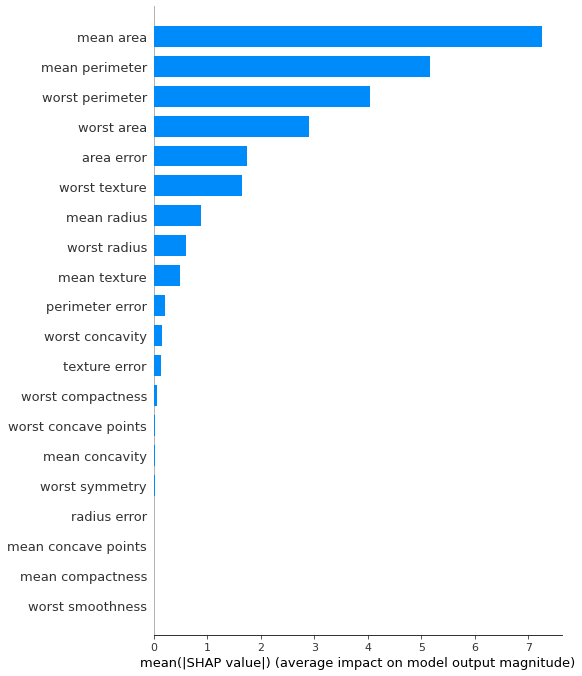

In [9]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

- Bar Length: The length of each bar corresponds to the average absolute SHAP value for that feature. Longer bars indicate features with higher importance.
- Feature Ordering: The features are typically ordered from the most important (top) to the least important (bottom).

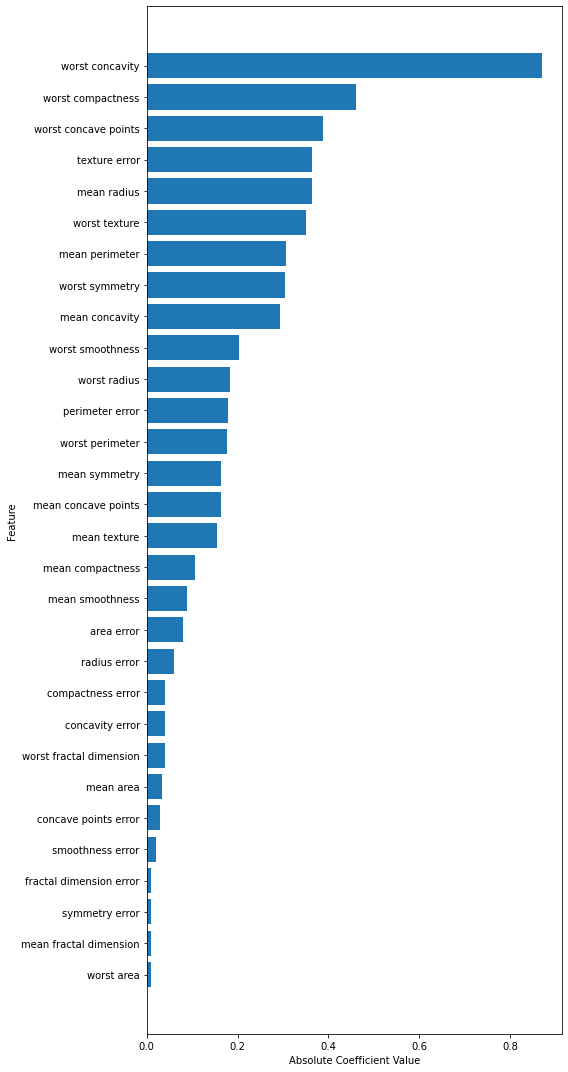

In [10]:
# What if we use the model parameters/coefficients? 

import matplotlib.pyplot as plt

coefficients = clf.coef_[0]  # Get the coefficients
feature_names = X_train.columns

# Calculate absolute values of coefficients
abs_coefficients = np.abs(coefficients)

# Sort coefficients and feature names by absolute coefficient values
sorted_indices = np.argsort(abs_coefficients)
sorted_coefficients = abs_coefficients[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Create the horizontal bar plot
plt.figure(figsize=(8, len(feature_names) * 0.5))  # Adjust figure size based on number of features
plt.barh(sorted_feature_names, sorted_coefficients)
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout() 
plt.show()